__Modeling Runners’ Times in the Cherry Blossom Race__

*Oscar Padilla*

# Introduction
The R code below was mainly developed in [Chapter 2] (http://rdatasciencecases.org/CherryBlossom/code.R) of the book by Deborah Nolan and Duncan Temple Lang called “Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving” [1]. 
This original code was modified, as needed, in order to solve question (7) in the Exercises section.

# Background

In this case study, authors [1] use the results (from 1999 to 2012) of the Cherry Blossom Ten Mile Run (Washington D.C.) in order to understand how people’s physical performance changes as they age.

Publicly available race results can be found at: http://www.cherryblossom.org/

Although, data and formatting is not consitent year over year, generally speaking, each result file contains at minimum:

- Runner's finishing __place__
- __Name__
- __Age__
- __Hometown__
- __Time__

<img src = "http://rdatasciencecases.org/CherryBlossom/figures/Men2011ResultsSS.png" >

- __Figure 1:__ Screen Shot of the 2011 Male Results

__Question 7)__ Follow the approach developed in the section called [3.1] “Reading Tables of Race Results into R” to read the files for the female runners and then process them using the functions in the section called [3.2] “Data Cleaning and Reformatting Variables” to create a data frame for analysis. You may need to generalize the `createDF()` and `extractVariables()` functions to handle additional oddities in the raw text files.

# Methods

In this section the code developed in Chapter 2 of NTL [1] is followed and modified as necessary in order to make it compatible to the female runners dataset. 

## Reading Tables of Race Results into R

In [1]:
source_path = getwd()

- findColLocs (function)

> to find the starting and ending positions of the columns into a function. In the function, we safeguard against the last character in the row of ‘=’ characters not being a blank, we add an additional element to the end of the vector of locations that is one character more than the length of the string [1].

In [2]:
findColLocs = function(spacerRow) {
  
  spaceLocs = gregexpr(" ", spacerRow)[[1]]
  rowLength = nchar(spacerRow)
  
  if (substring(spacerRow, rowLength, rowLength) != " ")
    return( c(0, spaceLocs, rowLength + 1))
  else return(c(0, spaceLocs))
}

- selectCols (function)

> to extract name, age, hometown, and all 3 times, i.e., gun time, net time, and time, and ignore the rest, e.g., place, div, and the 5-mile run time [1].

In [3]:
selectCols = function(shortColNames, headerRow, searchLocs) {
  sapply(shortColNames, function(shortName, headerRow, searchLocs){
    
    startPos = regexpr(shortName, headerRow)[[1]]
    
    if (startPos == -1) return( c(NA, NA) )
    
    index = sum(startPos >= searchLocs)
    c(searchLocs[index] + 1, searchLocs[index + 1])
  }, 
  
  headerRow = headerRow, searchLocs = searchLocs )
}

- extractVariables (function) - modified to locate footnote rows

> wrap up the process of extracting the columns into a function so we can apply it to
each year’s data [1].

In [4]:
extractVariables = 
  function(file, varNames =c("name", "home", "ag", "gun",
                             "net", "time"))
  {
    eqIndex = grep("^===", file)

    spacerRow = file[eqIndex] 
    headerRow = tolower(file[ eqIndex - 1 ])
    body = file[ -(1 : eqIndex) ]

    footnotes = grep("^[[:blank:]]*(\\*|\\#)", body)
    if ( length(footnotes) > 0 ) body = body[ -footnotes ]
    blanks = grep("^[[:blank:]]*$", body)
    if (length(blanks) > 0 ) body = body[ -blanks ]
    
    searchLocs = findColLocs(spacerRow)
    locCols = selectCols(varNames, headerRow, searchLocs)
    
    Values = mapply(substr, list(body), start = locCols[1, ], 
                    stop = locCols[2, ])
    colnames(Values) = varNames
    
    return(Values)
  }

## Data Cleaning and Reformatting Variables

- convertTime (function)

> Time is stored as a string in the format: `hh:mm:ss`. We want time in a numeric format
so it can be more easily summarized and modeled. One possibility is to convert it to minutes,
i.e., `hh * 60 + mm + ss/60`. To carry out this computation, we must split the time field
up into its constituent pieces and convert each to numeric values. The `strsplit()` function
can be very helpful for splitting strings at, e.g., colons [1].

In [5]:
convertTime = function(time) {
  timePieces = strsplit(time, ":")
  timePieces = sapply(timePieces, as.numeric)
  sapply(timePieces, function(x) {
    if (length(x) == 2) x[1] + x[2]/60
    else 60*x[1] + x[2] + x[3]/60
  })
}

- createDF (function)

> to apply to the character matrices in menResMat & womenResMat and return a data frame with variables for analysis. We have 6 variables:
> - runner’s name
> - home town
> - age
> - 3 versions of time
>
> In addition to the conversion of character strings to numeric, we also create two new variables, `year` and `sex`.

In [6]:
createDF = function(Res, year, sex) 
{
  if ( !is.na(Res[1, 'net']) ) useTime = Res[ , 'net']
  else if ( !is.na(Res[1, 'gun']) ) useTime = Res[ , 'gun']
  else useTime = Res[ , 'time']
  
  useTime = gsub("[#\\*[:blank:]]", "", useTime)
  runTime = convertTime(useTime[ useTime != "" ])
  
  Res = Res[ useTime != "", ]
  age = gsub("X{2}\\s{1}?|\\s{3}?","0  ", Res[,'ag'])
  Res[, 'ag'] = age
  
  Results = data.frame(year = rep(year, nrow(Res)),
                       sex = rep(sex, nrow(Res)),
                       name = Res[ , 'name'], home = Res[ , 'home'],
                       age = as.numeric(Res[, 'ag']), 
                       runTime = runTime,
                       stringsAsFactors = FALSE)
  invisible(Results)
}

Load text files

In [7]:
mfilenames = paste(source_path, "/Data/mens", 1999:2012, ".txt", sep = "")
menFiles = lapply(mfilenames, readLines)
names(menFiles) = 1999:2012

wfilenames = paste(source_path, "/Data/womens", 1999:2012, ".txt", sep = "")
womenFiles = lapply(wfilenames, readLines)
names(womenFiles) = 1999:2012

Fix 2006 and then apply the *extractVariables()* function to menFiles and womenFiles to obtain
a list of character matrices.

In [8]:
separatorIdx = grep("^===", menFiles[["2006"]])
separatorRow = menFiles[['2006']][separatorIdx]
separatorRowX = paste(substring(separatorRow, 1, 63), " ", 
                      substring(separatorRow, 65, nchar(separatorRow)), 
                      sep = "")
menFiles[['2006']][separatorIdx] = separatorRowX

menResMat = sapply(menFiles, extractVariables)
menDF = mapply(createDF, menResMat, year = 1999:2012,
               sex = rep("M", 14), SIMPLIFY = FALSE)

separatorIdx = grep("^===", womenFiles[["2006"]])
separatorRow = womenFiles[['2006']][separatorIdx]
separatorRowX = paste(substring(separatorRow, 1, 63), " ", 
                      substring(separatorRow, 65, nchar(separatorRow)), 
                      sep = "")
womenFiles[['2006']][separatorIdx] = separatorRowX

womenFiles[[3]] = append(womenFiles[[3]], menFiles[[3]][4:5], after=3)

womenResMat = sapply(womenFiles, extractVariables)

womenDF = mapply(createDF, womenResMat, year = 1999:2012,
                 sex = rep("W", 14), SIMPLIFY = FALSE)

In [9]:
sapply(womenResMat, nrow)

1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 
2356 2166 2972 3334 3542 3899 4333 5435 5690 6397 8323 8853 9030 9730

In [10]:
age = sapply(womenResMat,
             function(x) as.numeric(x[ , 'ag']))

Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”

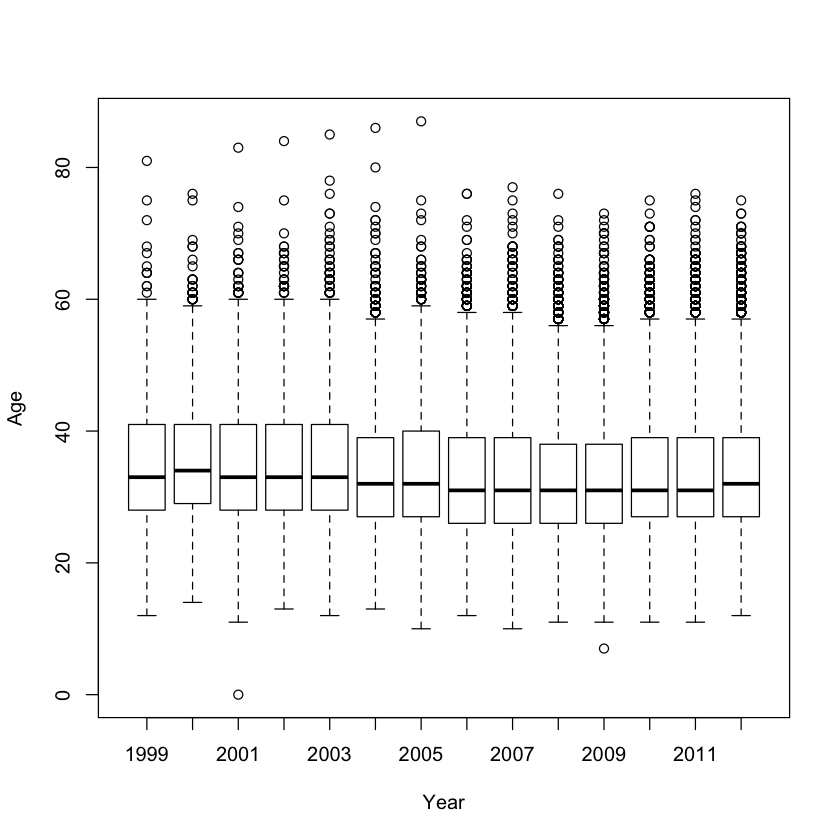

In [11]:
boxplot(age, ylab = "Age", xlab = "Year")

- __Figure 2:__ Box Plot of Womens' Age by Year

Check the number of NA values for `age`

In [12]:
sapply(age, function(x) sum(is.na(x)))

1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 
   4    0    0    4    0    0    8    1    2    0    2    0    0    0

Check the number of NA values for `runTime`

In [13]:
sapply(womenDF, function(x) sum(is.na(x$runTime)))

1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0

> We combine the race results for all years and men into one data frame using the
`do.call()` function to call `rbind()` with the list of data frames as input

In [14]:
cbMen = do.call(rbind, menDF)
cbWomen = do.call(rbind, womenDF)

save(cbMen, file = paste(source_path, "/Data/Men.rda", sep = ""))
save(cbWomen, file = paste(source_path, "/Data/Women.rda", sep = ""))

In [15]:
dim(cbWomen)

[1] 75972     6

In [16]:
head(cbWomen)

,year,sex,name,home,age,runTime
1999.1,1999,W,Jane Omoro,Kenya,26,53.61667
1999.2,1999,W,Jane Ngotho,Kenya,29,53.63333
1999.3,1999,W,Lidiya Grigoryeva,Russia,0,53.66667
1999.4,1999,W,Eunice Sagero,Kenya,20,53.91667
1999.5,1999,W,Alla Zhilyayeva,Russia,29,54.13333
1999.6,1999,W,Teresa Wanjiku,Kenya,24,54.16667


In [17]:
summary(cbWomen)

      year          sex                name               home          
 Min.   :1999   Length:75972       Length:75972       Length:75972      
 1st Qu.:2005   Class :character   Class :character   Class :character  
 Median :2008   Mode  :character   Mode  :character   Mode  :character  
 Mean   :2007                                                           
 3rd Qu.:2010                                                           
 Max.   :2012                                                           
      age           runTime      
 Min.   : 0.00   Min.   : 51.73  
 1st Qu.:27.00   1st Qu.: 88.53  
 Median :32.00   Median : 97.33  
 Mean   :33.84   Mean   : 98.09  
 3rd Qu.:39.00   3rd Qu.:106.78  
 Max.   :87.00   Max.   :177.52  

## Exploring the Run Time for All Female Runners
### Making Plots with Many Observations

Revised scatter plot with run time on the y-axis and age on the x-axis.

> `smoothScatter()` function provides a more formal approach to jittering and using
transparency for visualizing the density of runner’s time-age distribution. This function
produces a smooth density representation of the scatter plot using color

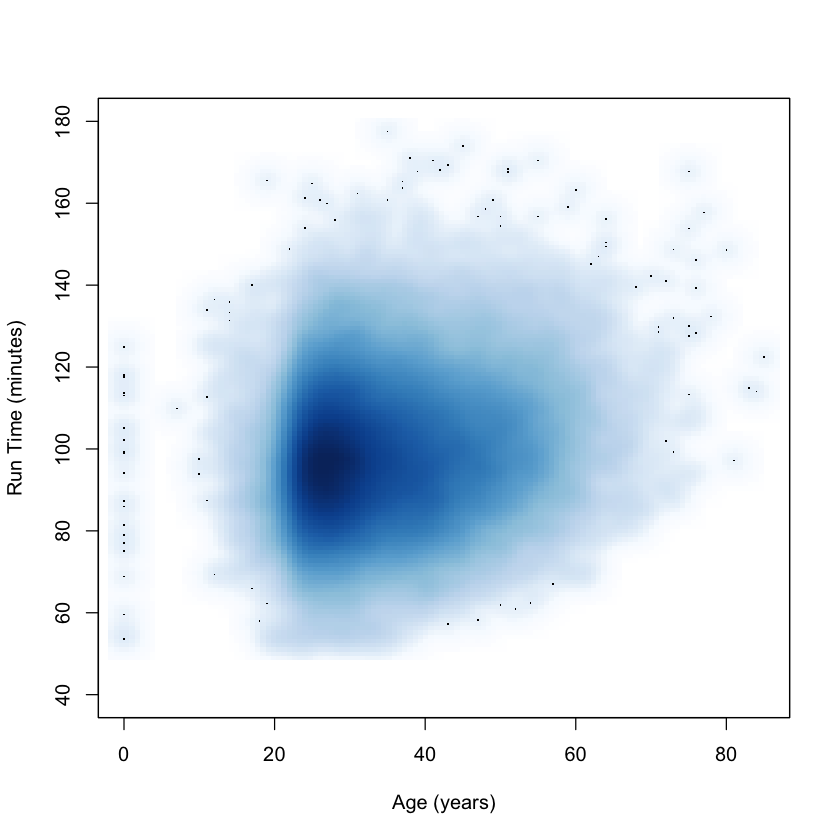

In [18]:
smoothScatter(y = cbWomen$runTime, x = cbWomen$age,
              ylim = c(40, 180), xlim = c(0, 85),
              xlab = "Age (years)", ylab = "Run Time (minutes)")

- __Figure 3:__ Smoothed Scatter Plot for Run Time vs. Age for Female Runners.

> Graphically display summary statistics of run time for subgroups of runners with roughly the same age. Here, we group the runners into 10-year age intervals and plot the summaries for each subgroup in the form of a boxplot

In [19]:
cbWomenSub = cbWomen[cbWomen$runTime > 30 & !is.na(cbWomen$age) & cbWomen$age > 15, ]
ageCat = cut(cbWomenSub$age, breaks = c(seq(15, 75, 10), 90))
table(ageCat)

ageCat
(15,25] (25,35] (35,45] (45,55] (55,65] (65,75] (75,90] 
  12926   35815   17520    7515    1849     183      15 

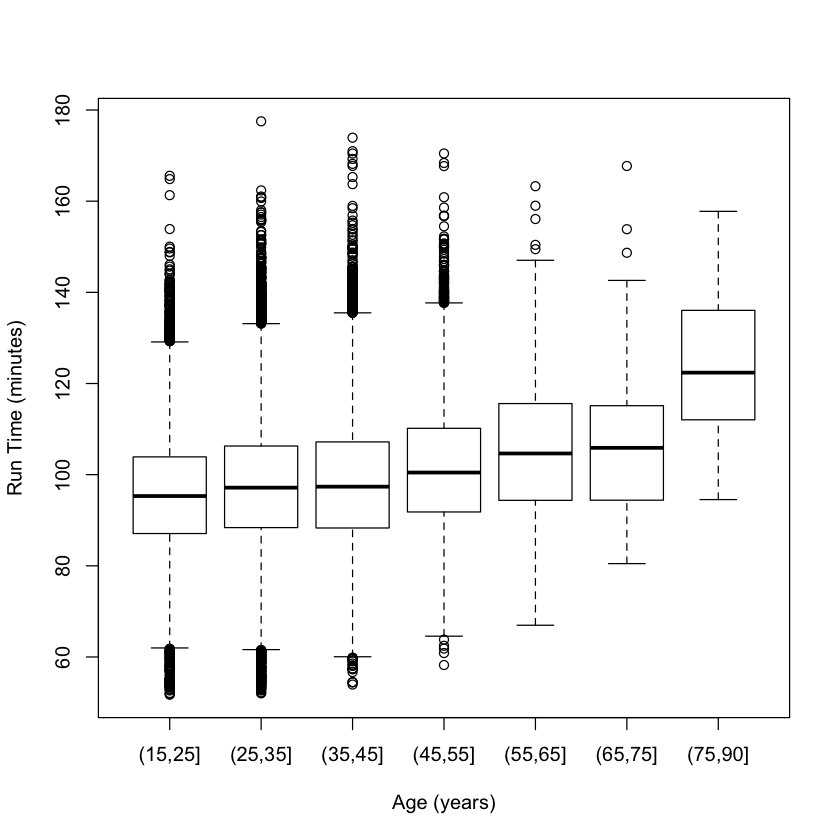

In [20]:
plot(cbWomenSub$runTime ~ ageCat, xlab = "Age (years)", ylab = "Run Time (minutes)")

- __Figure 4:__ Side-by-Side Boxplots of Female Runners’ Run Time vs. Age

Similarly to the Men's boxplots, 
> We observe in this plot that the upper quartile increases faster with age than the median and lower quartile

### Fitting Models to Average Performance
>A simple linear model may be inadequate to describe this relationship. To see how well the simple linear model captures the relationship (or not) between run time and age, we fit the model with

In [21]:
lmAge = lm(runTime ~ age, data = cbWomenSub)
summary(lmAge)


Call:
lm(formula = runTime ~ age, data = cbWomenSub)

Residuals:
    Min      1Q  Median      3Q     Max 
-46.093  -9.445  -0.648   8.639  79.208 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 91.330105   0.195631  466.85   <2e-16 ***
age          0.199396   0.005572   35.78   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 14.1 on 75821 degrees of freedom
Multiple R-squared:  0.01661,	Adjusted R-squared:  0.01659 
F-statistic:  1280 on 1 and 75821 DF,  p-value: < 2.2e-16


> To help us further discern any pattern in the residuals, we augment this residual plot with a smooth curve of local averages of the residuals from the fit. We fit the curve using `loess()` with

In [22]:
resid.lo = loess(resids ~ age, data = data.frame(resids = residuals(lmAge), 
                                                 age = cbWomenSub$age))

Based on `Figure 3`, we start by making a vector of age values from 20 to 80 and then,
> We can obtain these predicted values from the `predict.loess()` function. This function takes the loess object from a fit, e.g., `resid.lo` and a data frame with variables matching those used in the loess curve fitting, in this case age.

>We consider two approaches to a more complex fit: a piecewise linear model and a nonparametric smooth curve. For the latter, we simply take local weighted averages of time as
age varies, just as we smoothed the residuals from the linear fit. We use `loess()` again to do this with `womenRes.lo`, and then we make predictions for all ages ranges from 20 to 80 with `womenRes.lo.pr`

In [23]:
age20to80 = 20:80

resid.lo.pr = predict(resid.lo, newdata = data.frame(age = age20to80))

womenRes.lo = loess(runTime ~ age, cbWomenSub)

womenRes.lo.pr = predict(womenRes.lo, data.frame(age = age20to80))

In order to fit a piecewise linear model,

> We place hinges at 30, 40, 50, and 60 and thus allow the slope of the line to change at these decade markers.

In [24]:
decades = seq(30, 60, by = 10)
overAge = lapply(decades,
                 function(x) pmax(0, (cbWomenSub$age - x)))
names(overAge) = paste("over", decades, sep = "")
overAge = as.data.frame(overAge)
tail(overAge)

,over30,over40,over50,over60
75818,9,0,0,0
75819,10,0,0,0
75820,1,0,0,0
75821,25,15,5,0
75822,10,0,0,0
75823,8,0,0,0


For the piecewise model

$runTime = f(age, over30, over40, over50, over60)$

> We find the least squares fit with

In [25]:
lmPiecewise = lm(runTime ~ . , data = cbind(cbWomenSub[, c("runTime", "age")], overAge))
summary(lmPiecewise)


Call:
lm(formula = runTime ~ ., data = cbind(cbWomenSub[, c("runTime", 
    "age")], overAge))

Residuals:
    Min      1Q  Median      3Q     Max 
-46.020  -9.435  -0.667   8.643  79.517 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 87.44984    0.67288 129.963   <2e-16 ***
age          0.35777    0.02490  14.370   <2e-16 ***
over30      -0.39439    0.03898 -10.117   <2e-16 ***
over40       0.38491    0.04218   9.125   <2e-16 ***
over50       0.10086    0.06885   1.465    0.143    
over60      -0.02563    0.13087  -0.196    0.845    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 14.08 on 75817 degrees of freedom
Multiple R-squared:  0.01969,	Adjusted R-squared:  0.01963 
F-statistic: 304.6 on 5 and 75817 DF,  p-value: < 2.2e-16


In [26]:
overAge20 = lapply(decades, function(x) pmax(0, (age20to80 - x)))
names(overAge20) = paste("over", decades, sep = "")
overAgeDF = cbind(age = data.frame(age = age20to80), overAge20)
tail(overAgeDF)

,age,over30,over40,over50,over60
56,75,45,35,25,15
57,76,46,36,26,16
58,77,47,37,27,17
59,78,48,38,28,18
60,79,49,39,29,19
61,80,50,40,30,20


In [27]:
predPiecewise = predict(lmPiecewise, overAgeDF)

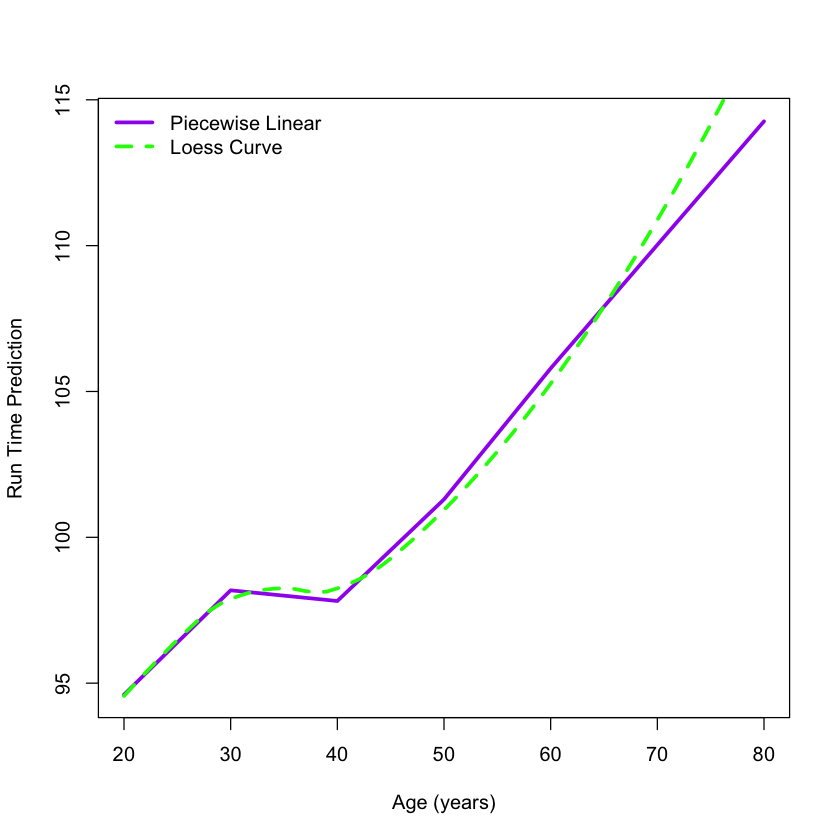

In [28]:
plot(predPiecewise ~ age20to80, type = "l", col = "purple", lwd = 3,
     xlab = "Age (years)", ylab = "Run Time Prediction")

lines(x = age20to80, y = womenRes.lo.pr, col = "green", lty = 2, lwd = 3)
legend("topleft", col = c("purple", "green"), lty = c(1, 2), lwd= 3,
       legend = c("Piecewise Linear", "Loess Curve"), bty = "n")

- __Figure 5:__ Piecewise Linear and Loess Curves Fitted to Run Time vs. Age

Figure 5 clearly shows that there is a changepoint at the age of 30 when run time deterioration slows down and another chagepoint at the age of 40 when run time deterioration accelerates dramatically.

# Results

In this section,  the analysis of female runners' run times as function of age is continued although the `changepoint` R package is utilized in the first subsection [4.1]. While in the subsequent subsection [4.2] the automatic LOESS R functions are applied.

## Changepoint Detection

### Data Preparation

In order to utilize the `changepoint` package data needs to be formatted as a quasi time series. Data was first summarized usin the mean function, but as it was detected in `Figure 4`, variance increases drastically after age 60. The median function yielded similar results. The best run time (minimum) provided a more 'stable' result.

In [29]:
library(plyr)

In [30]:
runTimebyage = ddply(cbWomenSub, ~ age, summarize, min = min(runTime))

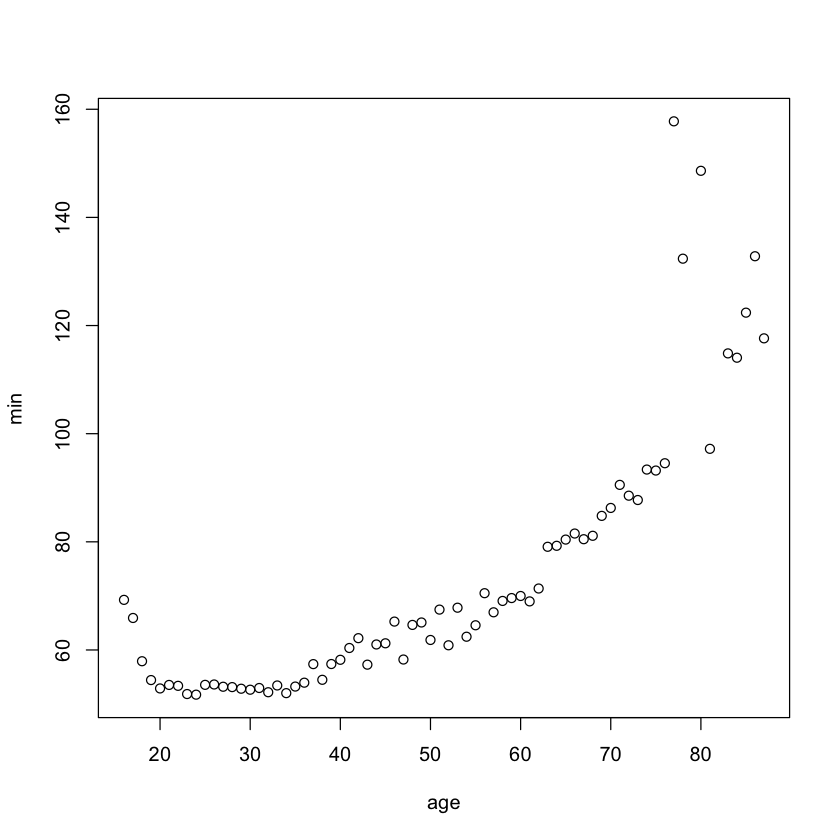

In [31]:
plot(min ~ age, data = runTimebyage)

- __Figure 6:__ Scatter Plot of Age vs. Best (MIN) Run Time

In [32]:
head(runTimebyage)

age,min
16,69.26667
17,65.91667
18,57.91667
19,54.43333
20,52.88333
21,53.53333


In [33]:
library(changepoint)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Successfully loaded changepoint package version 2.2.2
 NOTE: Predefined penalty values changed in version 2.2.  Previous penalty values with a postfix 1 i.e. SIC1 are now without i.e. SIC and previous penalties without a postfix i.e. SIC are now with a postfix 0 i.e. SIC0. See NEWS and help files for further details.


### Changes in Mean

In [34]:
m.pelt <- cpt.mean(runTimebyage$min, penalty = "Manual", pen.value = "50 * log(n)",
                   method = "PELT")

In [35]:
m.pelt

Class 'cpt' : Changepoint Object
       ~~   : S4 class containing 12 slots with names
              cpttype date version data.set method test.stat pen.type pen.value minseglen cpts ncpts.max param.est 

Created on  : Sun Feb  3 22:59:05 2019 

summary(.)  :
----------
Created Using changepoint version 2.2.2 
Changepoint type      : Change in mean 
Method of analysis    : PELT 
Test Statistic  : Normal 
Type of penalty       : Manual with value, 212.4248 
Minimum Segment Length : 1 
Maximum no. of cpts   : Inf 
Changepoint Locations : 2 24 40 47 54 61 64 65 

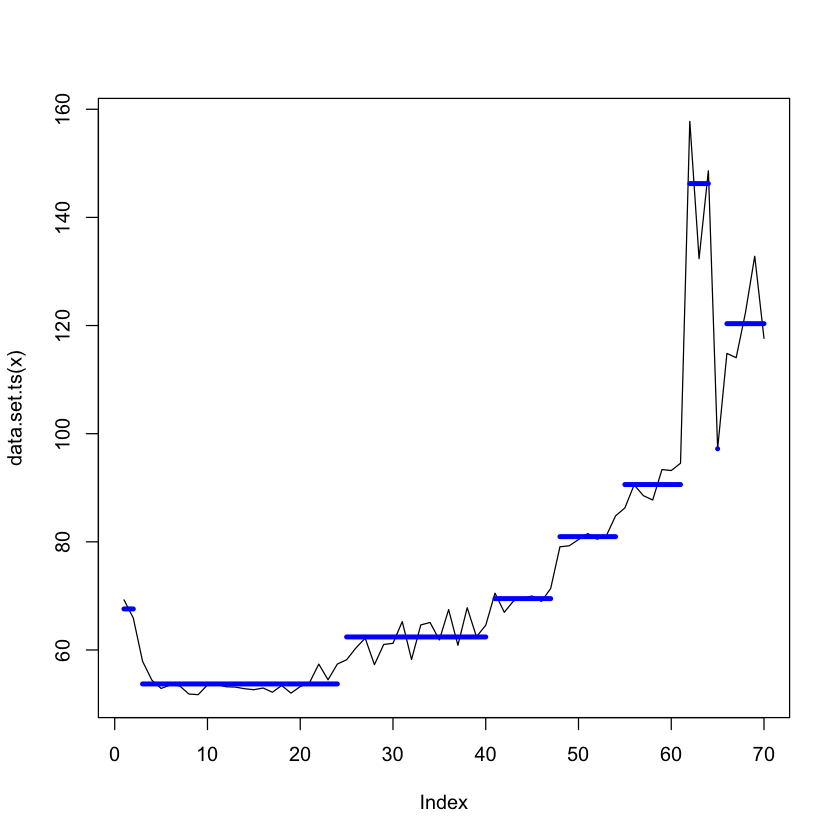

In [36]:
plot(m.pelt, type = "l", cpt.col = "blue", xlab = "Index", cpt.width = 4)

- __Figure 7:__ PELT Changepoints of Run Time vs. Age (~Index)

After trying different values, results seem to be insensitive to the manual penalty applied `pen.value = "50 * log(n)`. 

In [37]:
m.binseg <- cpt.mean(runTimebyage$min, "Manual", pen.value = "50 * log(n)", method = "BinSeg")

Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”

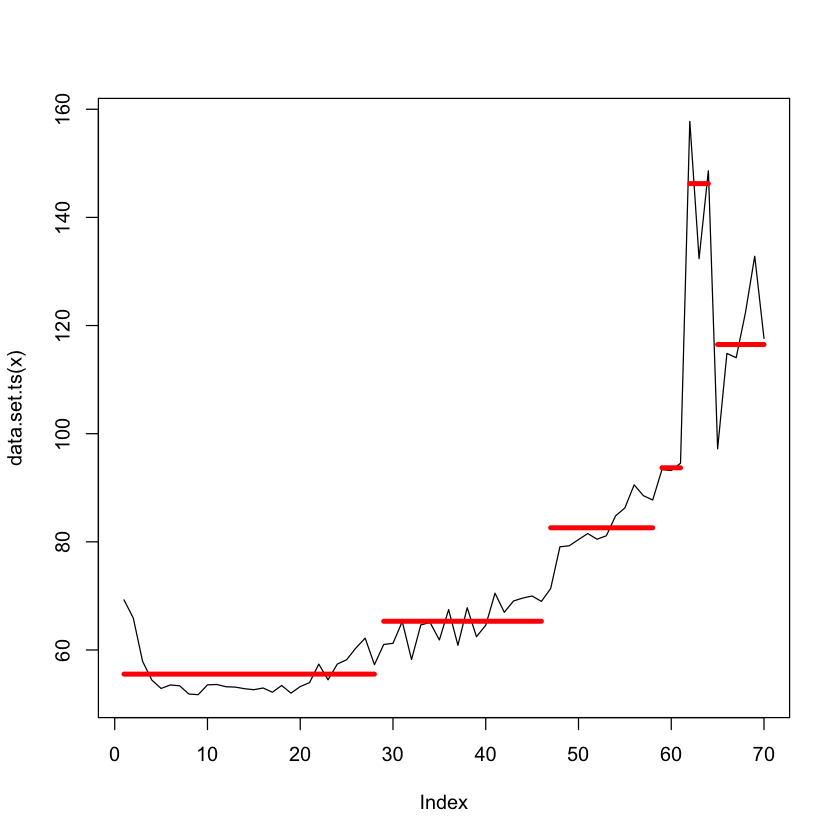

In [38]:
plot(m.binseg, type = "l", xlab = "Index", cpt.width = 4)

- __Figure 8:__ Binary Segmentation Changepoints of Run Time vs. Age (~Index)

Binary Segmentation yields a lower number of changepoints (5 vs. 8) than the PELT method. Although it also seems to be insentive to the manual penalty applied.

### Changes in Variance

In [39]:
 m.varPELT <- cpt.var(diff(runTimebyage$min), method = "PELT")

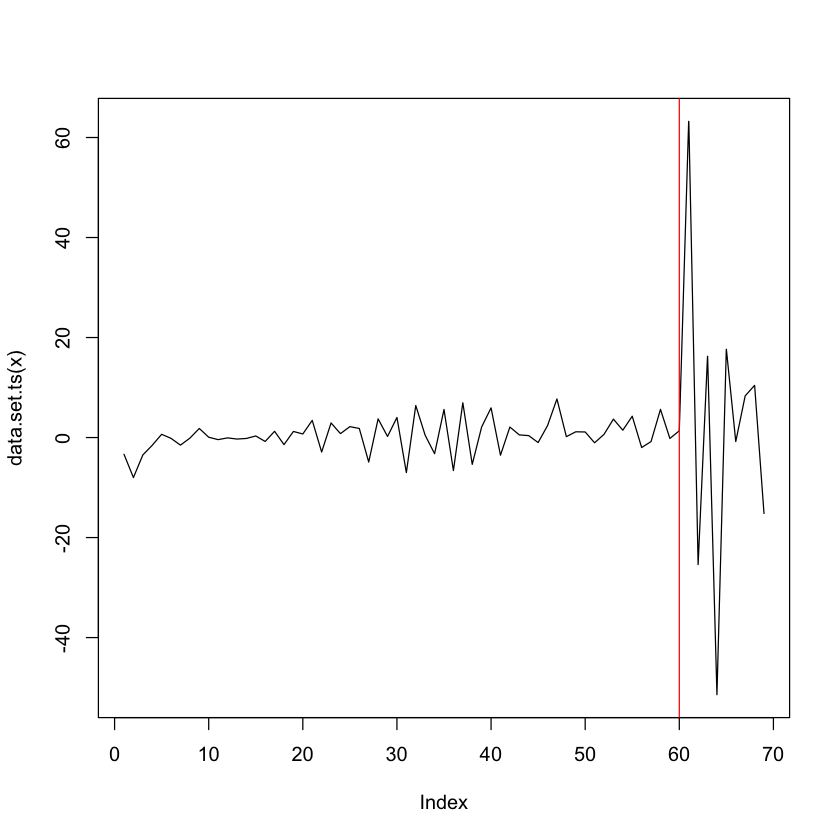

In [40]:
plot(m.varPELT, xlab = "Index")

- __Figure 9:__ Changes in Variance (PELT Method)

Both methods PELT and Binary Segmentation (not shown), yield only one variance changepoint at the age of 60

### Changes in Mean and Variance

[1]  3 21 40 47 53 61

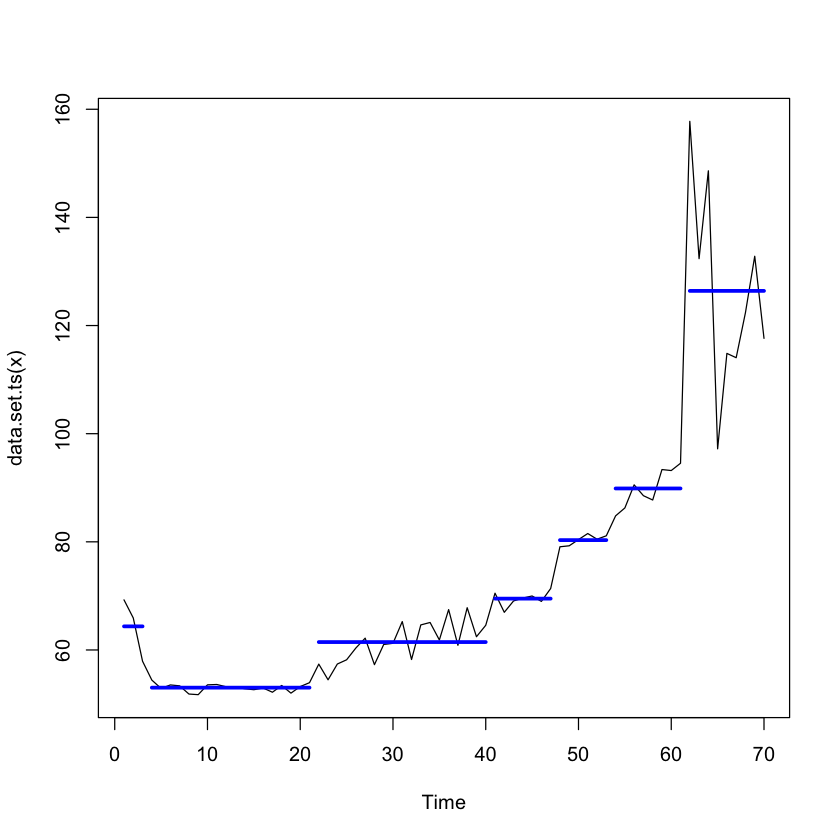

In [41]:
dis.pelt <- cpt.meanvar(runTimebyage$min, test.stat = "Normal", method = "PELT")
cpts.ts(dis.pelt)
plot(dis.pelt, cpt.col = "blue", cpt.width = 3)

- __Figure 10:__ Changes in Mean and Variance (PELT Method)

[1] 32 47 53 61

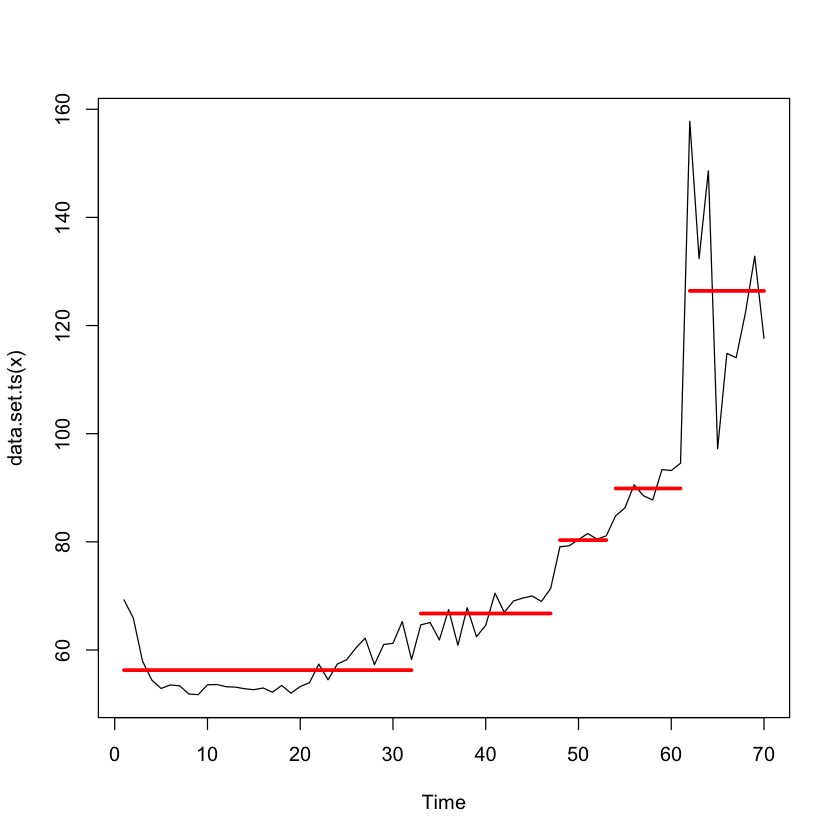

In [42]:
dis.bs <- cpt.meanvar(runTimebyage$min, test.stat = "Normal", method = "BinSeg")
cpts.ts(dis.bs)
plot(dis.bs, cpt.col = "red", cpt.width = 3)

- __Figure 11:__ Changes in Mean and Variance (Binary Segmentation Method)

Both methods, PELT (6 changepoints) and Binary Segmentation (4 changepoints), produce very similar results. The assumption of change in mean __and__ variance despite of the method is the best course of action for this dataset.

## LOESS

In [43]:
library(ggplot2)

In [44]:
loessresp10 <- loess(runTime ~ age, data = cbWomenSub, span = 0.10)
smooth10 <- predict(loessresp10)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 31”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 1”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1”

In [45]:
loessresp25 <- loess(runTime ~ age, data = cbWomenSub, span = 0.25)
smooth25 <- predict(loessresp25)

In [46]:
loessresp50 <- loess(runTime ~ age, data = cbWomenSub, span = 0.50)
smooth50 <- predict(loessresp50)

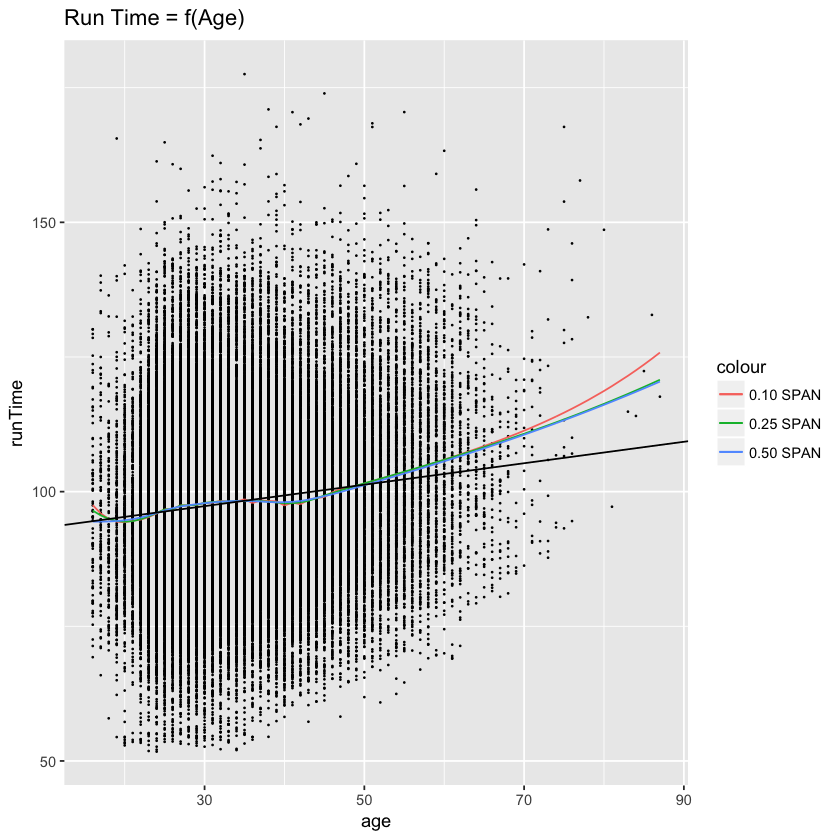

In [47]:
loesspplot <- ggplot(data = cbWomenSub, aes(x = age, y = runTime)) + 
ggtitle("Run Time = f(Age)") +
geom_point(size = 0.10) +
geom_line(aes(y = smooth10, color = "0.10 SPAN")) +
geom_line(aes(y = smooth25, color = "0.25 SPAN")) +
geom_line(aes(y = smooth50, color = "0.50 SPAN")) + 
geom_abline(intercept = coef(lmAge)[1], slope = coef(lmAge)[2])
loesspplot

- __Figure 12:__ Simple Linear Model vs. LOESS with different Spans (0.10, 0.25, 0.50)

The results in `Figure 12` follow the same pattern as those in `Figure 5` where the authors developed a "manual" Piecewise linear model (i.e changepoints at 30 and 40).
Although there seems to be a clear difference between span 0.10 and 0.25, 0.50 is virtually the same as 0.25.


# Conclusions

- "The devil is in the details" when it comes to data transformation. Format and content changes make the data extraction an intricate and time consuming task
- Simple linear model is inadequate to describe the relationship of athletic performance (i.e. run times) vs. age because there is a clear changepoint (e.g. 40 years) where variance and performance deterioration accelerate
- The "manual" Piecewise linear model developed by the authors yields very similar results to the automatic LOESS function (i.e changepoints at 30 and 40), although results seem to be insensitive to the span after 0.25
- Changepoints detected by the `changepoint` package yield better results when we assume changes in mean and variance when applied to this particular dataset


# References

1. Nolan, D., and Temple Lang, D. (2015), *Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving.* Boca Raton, FL: CRC Press (NTL)

2. Brown, Zach, *Modeling Runners’ Times in the Cherry Blossom Race*, https://rpubs.com/xzachx/351788

3. Killick, Rebecca, Eckley, Idris, Journal os Statistical Software, June 2014, Volume 58, Issue 3, *changepoint: An R Package for Changepoint Analysis*